In [2]:
from PIL import Image
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split
from ultralytics import SAM
import matplotlib.pyplot as plt
import math
from torch.cuda import is_available
from pathlib import Path
from scipy import ndimage
from tqdm import tqdm
from joblib import delayed, Parallel
from hashlib import md5
import seaborn as sbn

In [3]:
def draw(images : list):
    images_per_row = 2

    num_rows = len(images) // images_per_row + int(len(images) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(images):
            ax = axes.flat[i]
            img = images[i]

            ax.imshow(img)
            ax.axis('off')
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def coords_processing(mask, coords):
    coastline_coords = []
    row, col = mask.shape

    for coord in coords:
        r, c = coord[0], coord[1]
        neighbours = []

        for j in range(r - 1, r + 2):
            for k in range(c - 1, c + 2):
                if (0 <= j < row) and (0 <= k < col) and j != r and k != c:
                    neighbours.append(int(mask[j][k]))

        if any([neigh not in [1,3,5] for neigh in neighbours]):
            coastline_coords.append((r, c))

    return coastline_coords

In [5]:
def get_coastlines(img : np.ndarray, mask : np.ndarray):
    if mask.shape.__len__() >= 3:
        raise ValueError('Expected 2-dim mask')
    row, col = mask.shape

    coastlines_coord = []
    coords = np.argwhere(mask == 255)
    #np.append(coords, np.argwhere(mask == 1))
    #np.append(coords, np.where(mask == 3))

    if coords.shape[0] == 0:
        return np.array([])

    PROCESS_COUNT = math.ceil(np.log2(coords.shape[0]))

    print(f'Mask shape {mask.shape} | Coordinates count : {coords.shape[0]} | Process count : {PROCESS_COUNT} |  Expected time : {coords.shape[0] * 9 / 1e6 }s')

    one_range = len(coords) // PROCESS_COUNT
    ranges = [(one_range * i, one_range * (i + 1)) for i in range(PROCESS_COUNT - 1)]
    ranges += [(ranges[-1][1], len(coords))]

    values = Parallel(n_jobs=PROCESS_COUNT)(delayed(coords_processing)(mask, coords[r[0] : r[1]]) for r in ranges)        
    for val in values:
        coastlines_coord.extend(val)

    return np.array(coastlines_coord)

In [45]:
def renderPlots(images : list, verbose=True):
    if verbose == False:
        %matplotlib agg
    else:
        plt.ion()
        plt.show()
        %matplotlib inline

    fig, axes = plt.subplots(ncols=len(images), figsize=(15,15))
    if len(images) == 1:
        axes = [axes]
    names = ['Source image', 'Erode+Dilate', 'Closing', 'Distance Transforming (*)', '(*) threshold']
    for i in range(len(images)):
        axes[i].imshow(images[i])
        axes[i].set_title(names[i])

    return fig

In [8]:
def getCoastlineDistance(img : np.ndarray, mode='S'):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (11,11), sigmaX=2, sigmaY=2)
    row, col, _ = img.shape

    erode_kernel = np.ones((3,3), np.uint8)
    dilate_kernel = np.ones((5,5), np.uint8)

    adaptiveThresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
    ret, thresh = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    thresh = np.uint8(thresh + adaptiveThresh)

    #dilate = cv.dilate(erode, dilate_kernel, iterations=10).astype(np.uint8)
    erode = cv.erode(thresh, erode_kernel, iterations=2).astype(np.uint8)
    erode = cv.dilate(erode, erode_kernel, iterations=3).astype(np.uint8)

    rotated_positive = cv.resize(ndimage.rotate(erode, 1), (col, row), fx=1, fy=1, interpolation=cv.INTER_CUBIC)
    rotated_negative = cv.resize(ndimage.rotate(erode, -1), (col, row), fx=1, fy=1, interpolation=cv.INTER_CUBIC)
    
    erode = np.uint8(rotated_negative + rotated_positive + erode)

    closing = cv.morphologyEx(erode, kernel=dilate_kernel, iterations=10, op=cv.MORPH_CLOSE)
    closing = 255 - closing

    ret, closing = cv.threshold(closing, 128, 255, cv.THRESH_BINARY)

    dist = cv.distanceTransform(closing, cv.DIST_L2, 0)
    dist = cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)

    if mode == 'W':
        fig = renderPlots([img, thresh, erode, closing, dist], verbose=False)
        plt.savefig('./figures/' + md5(img).hexdigest() + '.jpg')
    elif mode == 'V':
        _ = renderPlots([img, thresh, erode, closing, dist])
        plt.show()
        plt.clf()

    return dist, erode, closing

def getMarkers(src : np.ndarray, dist : np.ndarray, dilate : np.ndarray, closing : np.ndarray, mode='S'):
    cnts, val = np.histogram(dist.ravel())
    grad = np.abs(np.gradient(cnts)[1:]) # skip first delta

    thresh_coef = val[np.argmax(grad) + 1]
    ret, dist_thresh = cv.threshold(dist, thresh_coef, 255, cv.THRESH_BINARY)
    dist_thresh = dist_thresh.astype(np.uint8)

    dist_thresh = cv.bitwise_and(dist_thresh, closing)

    #dist_thresh =  ndimage.binary_fill_holes(dist_thresh, structure=np.ones((5, 5))).astype(np.uint8)
    
    s = cv.subtract(closing, dist_thresh)

    ret, markers = cv.connectedComponents(dist_thresh)
    #markers += 1    

    markers[s == 255] = 0

    if mode == 'W':
        _ = renderPlots([dist_thresh, s, markers], verbose=False)
        plt.savefig('./figures/' + md5(src).hexdigest() + '_2.jpg')
    elif mode == 'V':
        print(thresh_coef)
        _ = renderPlots([dist_thresh, s, markers])
        plt.show()
        plt.clf()

    return markers, dist_thresh

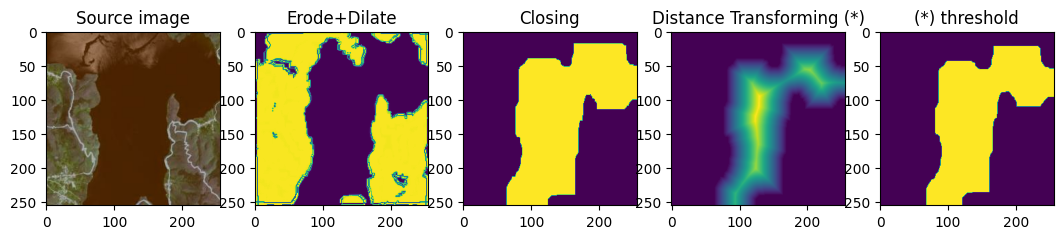

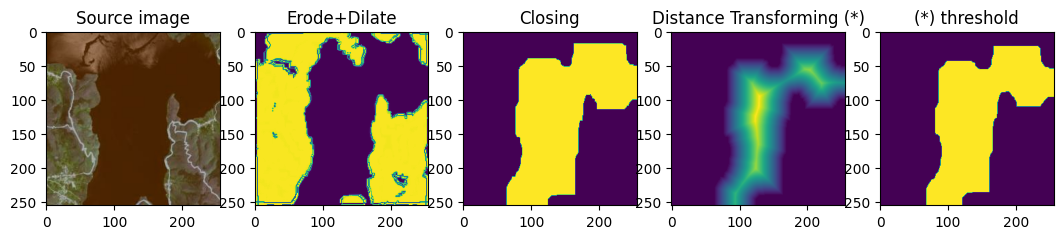

In [46]:
images = [path for path in Path('./satellite-images-4/train/images').iterdir()]
img = cv.imread(images[3])
dist, erode, closing = getCoastlineDistance(img)
markers, dist_tresh = getMarkers(img, dist, erode, closing)
renderPlots([img, erode, closing, dist, dist_tresh])

In [7]:
def processMask(path : str):
    gray = cv.imread(path, cv.IMREAD_GRAYSCALE)
    blur = cv.GaussianBlur(gray, (5, 5), 2, 2)
    ret, thresh = cv.threshold(blur, 128, 255, cv.THRESH_BINARY)

    row, col = gray.shape
    pipe = cv.erode(thresh, np.ones((2,2), np.uint8), iterations=3)
    pipe = cv.dilate(pipe, np.ones((2,2), np.uint8), iterations=3)
    pipe = ndimage.binary_fill_holes(pipe).astype(np.uint8)
    
    conts, hier = cv.findContours(pipe, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if len(conts) == 0:
        return np.zeros((col, row), np.uint8)
    
    greatest = max(conts, key=cv.contourArea)

    mask = np.zeros((col, row), np.uint8)
    mask = cv.drawContours(mask, [greatest], -1, 255, 1)
    return mask

In [8]:
# idx = np.arange(len(kaggle_dataset_label))
# np.random.shuffle(idx)
# idx = idx[:30]

# for i in idx:
#     path = kaggle_dataset_label[f'{i}.jpg']
#     fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

#     mask = processMask(path)
#     ax1.imshow(cv.imread(path))
#     ax2.imshow(mask)

#     plt.savefig(f'./temp/{str(path).split('\\')[-1]}')
#     plt.clf()

In [22]:
images = [[f'./data/masks/{path.name}', f'./data/images/{path.name}'] for path in Path('data/images').iterdir()]
images = images[:len(images) // 4]

In [23]:
train_primary, test = train_test_split(images, test_size=0.3)
train, val = train_test_split(train_primary, test_size=0.3)

In [26]:
def writeImage(type, data):
    for pair in data:
        mask = processMask(pair[0])
        img = cv.imread(pair[1])
        name = pair[0].split('/')[-1]

        cv.imwrite(f'./UNet-3-Plus/dataset/{type}/images/{name}', img)
        cv.imwrite(f'./UNet-3-Plus/dataset/{type}/mask/{name}', mask)

In [27]:
writeImage('test', test)
writeImage('train', train)
writeImage('val', val)

In [16]:
removeFrom('./UNet-3-Plus/dataset/val/images/')
removeFrom('./UNet-3-Plus/dataset/val/mask/')

In [39]:
import os
def removeFrom(path):
    for p in Path(path).iterdir():
        os.remove(p.absolute())

# Testing hq sam

In [2]:
import datasets

In [2]:
from segment_anything_hq import sam_model_registry

sam = sam_model_registry['vit_tiny'](checkpoint='./sam_hq_vit_tiny.pth')

C:\Users\Jesus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\segment_anything_hq\modeling\tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything_hq.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
C:\Users\Jesus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\segment_anything_hq\modeling\tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything_hq.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
C:\Users\Jesus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0

<All keys matched successfully>


In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="yvH0eHRR7gawMu7o1pdC")
project = rf.workspace("hackshit").project("satellite-images-xl3af")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.50, to fix: `pip install ultralytics==8.0.196`


## Preparing data

In [4]:
dataset = datasets.load_dataset('./satellite-images-4')

Resolving data files:   0%|          | 0/8700 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/628 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/516 [00:00<?, ?it/s]

In [5]:
train = dataset['train'].to_pandas()
val= dataset['validation'].to_pandas()
test = dataset['test'].to_pandas()

In [6]:
train['image'] = train['image'].apply(lambda x : x['path'])
val['image'] = val['image'].apply(lambda x : x['path'])
test['image'] = test['image'].apply(lambda x : x['path'])

In [7]:
def to_label(path : str):
    split = path.split('\\')
    split[-2] = 'labels'
    split[-1] = split[-1][:-3] + 'txt'
    return '\\'.join(split)


train['labels'] = train['image'].apply(lambda p : np.array(list(map(float, open(to_label(p)).readline().split()[1:]))))
test['labels'] = test['image'].apply(lambda p : np.array(list(map(float, open(to_label(p)).readline().split()[1:]))))
val['labels'] = val['image'].apply(lambda p : np.array(list(map(float, open(to_label(p)).readline().split()[1:]))))

In [8]:
def generateMaskFromPoints(points : np.ndarray, shape : list): # 1xN array
    if len(points) < 3:
        return np.zeros(shape, np.uint8)

    cont = points.copy().reshape(len(points) // 2, 2)
    cont[:, 0] *= shape[0]
    cont[:, 1] *= shape[1]

    cont = cont.reshape(len(cont), 1, 2).astype(np.intc)

    mask = np.zeros(shape, dtype=np.uint8)
    mask = cv.drawContours(mask, [cont], -1, 1, cv.FILLED)

    return mask

shape = [256, 256] # It's constant for all image
train['mask'] = train['labels'].apply(lambda x : generateMaskFromPoints(x, shape))
val['mask'] = val['labels'].apply(lambda x : generateMaskFromPoints(x, shape))
test['mask'] = test['labels'].apply(lambda x : generateMaskFromPoints(x, shape))

train['image'] = train['image'].apply(cv.imread)
val['image'] = val['image'].apply(cv.imread)
test['image'] = test['image'].apply(cv.imread)

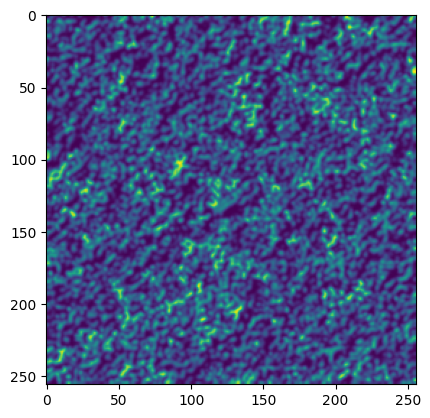

In [9]:
def compose(*functions):
    def inner(arg):
        for f in functions:
            arg = f(arg)
        return arg
    
    return inner

sigmoid = lambda z : 1 / (1 + np.exp(-z))

delegate = compose(sigmoid, lambda x : x * 255, np.uint8)
k_8 = delegate(np.random.normal(size=(8,8)))
k_32 = delegate(np.random.normal(size=(32,32)))
k_128 = delegate(np.random.normal(size=(128,128)))

k_8 = cv.resize(k_8, (256, 256), interpolation=cv.INTER_CUBIC)
k_32 = cv.resize(k_32, (256, 256), interpolation=cv.INTER_CUBIC)
k_128 = cv.resize(k_128, (256, 256), interpolation=cv.INTER_CUBIC)


plt.imshow(cv.GaussianBlur(cv.morphologyEx(k_8 + k_32 + k_128, op=cv.MORPH_TOPHAT, iterations=2, kernel=np.ones((2,2), dtype=np.uint8)), ksize=(11,11), sigmaX=1, sigmaY=1))

In [10]:
from noise import snoise2, perlin

def generate_water_noise(width, height):
    scale = np.random.normal(loc=400, scale=25)
    gen = perlin.SimplexNoise()
    gen.randomize()
    noise = sigmoid(1 - np.array([[gen.noise2(x / scale, y / scale) for x in range(width)] for y in range(height)]))
    noise = plt.cm.Blues(noise)[:, :, :3]
    
    alpha = np.random.normal(loc=0.5, scale=0.1)
    noise *= [alpha, alpha * np.random.normal(loc=1.0, scale=0.2), alpha]
    return noise


def generate_terrain(width, height):
    sigmoid = lambda z : 1 / (1 + np.exp(-z))

    delegate = compose(sigmoid, lambda x : x * 255, np.uint8)
    k_8 = delegate(np.random.normal(size=(8,8)))
    k_32 = delegate(np.random.normal(size=(32,32)))
    k_512 = delegate(np.random.normal(size=(512,512)))

    k_8 = cv.resize(k_8, (width, height), interpolation=cv.INTER_CUBIC)
    k_32 = cv.resize(k_32, (width, height), interpolation=cv.INTER_CUBIC)
    k_512 = cv.resize(k_512, (width, height), interpolation=cv.INTER_CUBIC)

    tophat = 255 - cv.morphologyEx(k_8 + k_32 + k_512, op=cv.MORPH_TOPHAT, kernel=np.ones((5,5), dtype=np.uint8))
    blur = cv.GaussianBlur(tophat, (11,11), 1, 1)
    terrain = plt.cm.YlGn(blur)[:, :, :3]

    alpha = np.random.normal(loc=0.5, scale=0.1)
    terrain *= [alpha, alpha, alpha]

    return terrain

In [21]:
for idx in tqdm(train.index):
    mask = train['mask'][idx]
    labels = list(train['labels'][idx])
    shape = mask.shape

    gen_water = generate_water_noise(shape[0], shape[1])
    gen_water[mask != 1] *= 0

    gen_terrain = generate_terrain(shape[0], shape[1])
    gen_terrain[mask == 1] *= 0
    gen_image = ((gen_terrain + gen_water) * 255).astype(np.float32)

    # Add shadow at mask contour
    conts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    if len(conts) == 0:
        continue

    cont = max(conts, key=cv.contourArea)

    shadow = np.zeros((256,256), np.uint8)
    shadow = cv.drawContours(shadow, [cont], -1, 1, 3)
    shadow = cv.dilate(shadow, kernel=np.ones((2,2), np.uint8), iterations=15)
    dist = cv.distanceTransform(shadow, cv.DIST_L2, maskSize=0)

    shadow = np.repeat(dist[..., np.newaxis], 3, axis=2).astype(np.float32)
    gen_image -= shadow
    gen_image[gen_image < 0] = 0
    gen_image = gen_image.astype(np.uint8)
    gen_image = np.array(Image.fromarray(gen_image).quantize(colors=8).convert('RGB'))

    #print(gen_image.shape)
    base = './synthetic-satellite/train'
    plt.imsave(base + f'/images/{idx}.jpg', gen_image)
    with open(base + f'/labels/{idx}.txt', 'w') as w:
        labels = ' '.join(map(str, labels))
        w.write(labels)
    

 12%|█▏        | 538/4350 [02:21<16:52,  3.76it/s]

: 